### Importing Required Modules

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim
import torchmetrics
from torchmetrics.classification import ConfusionMatrix, Accuracy, Precision, Recall, F1Score

In [2]:
np.random.seed(5)
torch.manual_seed(5)

### Importing Dataset

In [3]:
df=pd.read_csv('synthetic_traffic_data_with_congestion.csv')

In [4]:
df.head()

,Time,Traffic_Flow,Average_Speed,Occupancy,Temperature,Humidity,Wind_Speed,Precipitation,Visibility,Road_Condition,Traffic_Congestion
0,2024-01-01 00:00:00,102.0,95.208871,71.489953,24.730232,6.641042,1.613307,4.843614,5.615359,Snowy,Low
1,2024-01-01 01:00:00,435.0,22.227414,57.897765,8.805837,17.086020,27.731161,6.546673,0.003330,Snowy,Medium
2,2024-01-01 02:00:00,860.0,110.130299,1.460900,23.678285,31.112068,19.851620,19.707152,1.142456,Wet,High
3,2024-01-01 03:00:00,270.0,50.943291,36.037549,33.260058,32.069929,26.598680,7.363360,3.751952,Dry,Low
4,2024-01-01 04:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Snowy,Low


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Time                3000 non-null   object 
 1   Traffic_Flow        2700 non-null   float64
 2   Average_Speed       2700 non-null   float64
 3   Occupancy           2700 non-null   float64
 4   Temperature         2700 non-null   float64
 5   Humidity            2700 non-null   float64
 6   Wind_Speed          2700 non-null   float64
 7   Precipitation       2700 non-null   float64
 8   Visibility          2700 non-null   float64
 9   Road_Condition      2850 non-null   object 
 10  Traffic_Congestion  3000 non-null   object 
dtypes: float64(8), object(3)
memory usage: 257.9+ KB


### Data Preprocessing and Feature Engineering

In [6]:
null_counts = df.isnull().sum(axis=1)

In [7]:
df[null_counts<df.shape[1]/2].shape

(2700, 11)

In [8]:
#Deleting rows which contains more than 50% null values in it
df=df[null_counts<df.shape[1]/2]

In [9]:
df.head()

,Time,Traffic_Flow,Average_Speed,Occupancy,Temperature,Humidity,Wind_Speed,Precipitation,Visibility,Road_Condition,Traffic_Congestion
0,2024-01-01 00:00:00,102.0,95.208871,71.489953,24.730232,6.641042,1.613307,4.843614,5.615359,Snowy,Low
1,2024-01-01 01:00:00,435.0,22.227414,57.897765,8.805837,17.086020,27.731161,6.546673,0.003330,Snowy,Medium
2,2024-01-01 02:00:00,860.0,110.130299,1.460900,23.678285,31.112068,19.851620,19.707152,1.142456,Wet,High
3,2024-01-01 03:00:00,270.0,50.943291,36.037549,33.260058,32.069929,26.598680,7.363360,3.751952,Dry,Low
5,2024-01-01 05:00:00,71.0,97.889837,38.745130,0.729223,62.313292,3.938606,16.965885,1.335290,Dry,Low


In [10]:
target=df['Traffic_Congestion']

In [11]:
target.describe()

count     2700
unique       3
top       High
freq       930
Name: Traffic_Congestion, dtype: object

In [12]:
# Imputing target column
dit={'Low':0,'Medium':1,'High':2}

In [13]:
target=target.map(dit)

In [14]:
target.value_counts(),target.dtype

(Traffic_Congestion
 2    930
 0    889
 1    881
 Name: count, dtype: int64,
 dtype('int64'))

In [15]:
df.drop(columns=['Traffic_Congestion'],inplace=True)

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2700 entries, 0 to 2999
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Time            2700 non-null   object 
 1   Traffic_Flow    2700 non-null   float64
 2   Average_Speed   2700 non-null   float64
 3   Occupancy       2700 non-null   float64
 4   Temperature     2700 non-null   float64
 5   Humidity        2700 non-null   float64
 6   Wind_Speed      2700 non-null   float64
 7   Precipitation   2700 non-null   float64
 8   Visibility      2700 non-null   float64
 9   Road_Condition  2568 non-null   object 
dtypes: float64(8), object(2)
memory usage: 232.0+ KB


#### Handling Time Column

In [17]:
df.Time.isnull().sum()

0

In [18]:
df['Time']=pd.to_datetime(df.Time)

In [19]:
df.Time.info()

<class 'pandas.core.series.Series'>
Index: 2700 entries, 0 to 2999
Series name: Time
Non-Null Count  Dtype         
--------------  -----         
2700 non-null   datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 42.2 KB


In [20]:
# creating year column
df['year']=df.Time.dt.year

In [21]:
df['year'].value_counts()

year
2024    2700
Name: count, dtype: int64

In [22]:
# deleting year column as it has only one value
df.drop(columns=['year'],inplace=True)

In [23]:
# creating month column
df['month']=df.Time.dt.month_name()

In [24]:
df.month.value_counts()

month
January     679
March       667
April       642
February    628
May          84
Name: count, dtype: int64

In [25]:
# creating day column
df['day']=df.Time.dt.day_name()

In [26]:
df.day.value_counts()

day
Tuesday      396
Wednesday    393
Saturday     387
Monday       386
Thursday     385
Friday       382
Sunday       371
Name: count, dtype: int64

In [27]:
# dropping time column after extracting useful info
df.drop(columns='Time',inplace=True)

#### Handling Road_Condition Column

In [28]:
df.Road_Condition.value_counts()

Road_Condition
Dry      676
Snowy    664
Icy      642
Wet      586
Name: count, dtype: int64

In [29]:
df.Road_Condition.fillna('condition_unknown',inplace=True)

C:\Users\anush\AppData\Local\Temp\ipykernel_16176\1574599178.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df.Road_Condition.fillna('condition_unknown',inplace=True)


In [30]:
df.Road_Condition.value_counts()

Road_Condition
Dry                  676
Snowy                664
Icy                  642
Wet                  586
condition_unknown    132
Name: count, dtype: int64

### Checking Correlation

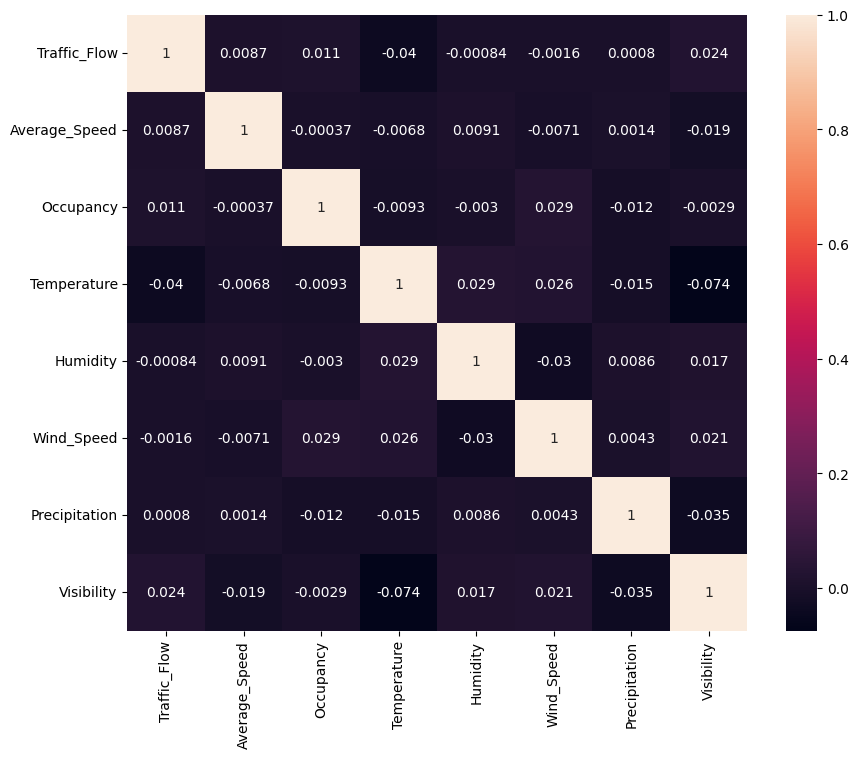

In [31]:
plt.figure(figsize=(10,8))
sns.heatmap(df.select_dtypes(include='number').corr(),annot=True)
plt.show()

### Checking Variance

In [32]:
var=df.select_dtypes(include='number').var()

In [33]:
var

Traffic_Flow     86940.463474
Average_Speed     1200.237086
Occupancy          830.448185
Temperature        167.037710
Humidity           820.902043
Wind_Speed          73.537841
Precipitation       33.635100
Visibility           8.366561
dtype: float64

### Checking Outliers

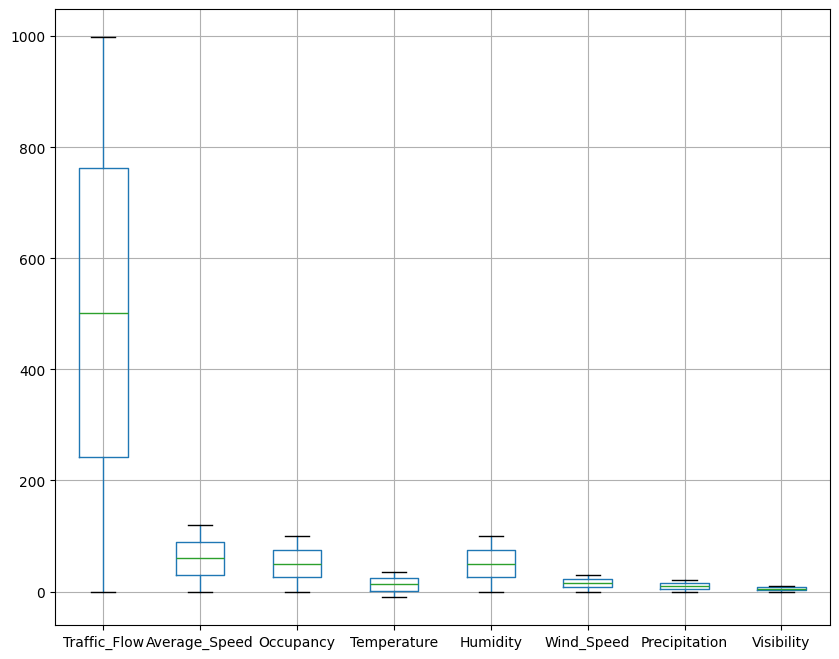

In [34]:
plt.figure(figsize=(10,8))
df.boxplot()
plt.show()

### One Hot Encoding and Standardization

In [35]:
df_duplicated=pd.get_dummies(df).astype('float32')

In [36]:
df_duplicated.head()

,Traffic_Flow,Average_Speed,Occupancy,Temperature,Humidity,Wind_Speed,Precipitation,Visibility,Road_Condition_Dry,Road_Condition_Icy,...,month_January,month_March,month_May,day_Friday,day_Monday,day_Saturday,day_Sunday,day_Thursday,day_Tuesday,day_Wednesday
0,102.0,95.208870,71.489952,24.730232,6.641042,1.613307,4.843615,5.615359,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,435.0,22.227413,57.897766,8.805837,17.086020,27.731161,6.546672,0.003330,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,860.0,110.130302,1.460900,23.678286,31.112068,19.851620,19.707151,1.142456,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,270.0,50.943291,36.037548,33.260059,32.069927,26.598679,7.363360,3.751952,1.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
5,71.0,97.889839,38.745129,0.729223,62.313293,3.938606,16.965885,1.335290,1.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [37]:
#Splitting Data
X_train, X_test,y_train,y_test = train_test_split(df_duplicated,target, test_size=0.2, random_state=42)

In [38]:
X_train.reset_index(drop=True,inplace=True)

In [39]:
X_test.reset_index(drop=True,inplace=True)

In [40]:
y_train.reset_index(drop=True,inplace=True)

In [41]:
y_test.reset_index(drop=True,inplace=True)

In [42]:
X_train.head()

,Traffic_Flow,Average_Speed,Occupancy,Temperature,Humidity,Wind_Speed,Precipitation,Visibility,Road_Condition_Dry,Road_Condition_Icy,...,month_January,month_March,month_May,day_Friday,day_Monday,day_Saturday,day_Sunday,day_Thursday,day_Tuesday,day_Wednesday
0,382.0,22.014288,75.600426,5.661357,97.562340,26.069164,17.942665,2.506411,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,181.0,50.972584,83.716194,33.240688,33.419670,10.616122,19.598366,0.584914,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,85.0,60.554283,86.343002,33.172092,26.039301,23.083981,9.458838,9.952803,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,664.0,45.183636,43.811165,33.045689,28.690355,11.013428,2.008591,8.102961,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,303.0,13.624877,89.486923,-3.577517,87.667953,7.356587,14.054790,1.972020,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [43]:
X_test.head()

,Traffic_Flow,Average_Speed,Occupancy,Temperature,Humidity,Wind_Speed,Precipitation,Visibility,Road_Condition_Dry,Road_Condition_Icy,...,month_January,month_March,month_May,day_Friday,day_Monday,day_Saturday,day_Sunday,day_Thursday,day_Tuesday,day_Wednesday
0,477.0,42.702572,26.067516,20.775202,32.899578,20.939281,6.094724,7.165725,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,644.0,55.200287,29.099939,-7.258950,95.875465,26.060392,18.302824,0.148318,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,215.0,27.630110,94.049721,1.394337,86.850647,17.046835,16.829014,4.472167,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,475.0,10.584205,0.776664,1.981056,13.061076,10.423733,17.251488,3.331801,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,112.0,55.595238,25.034027,12.627937,46.052734,9.935663,18.476688,0.448931,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [44]:
y_train.value_counts()

Traffic_Congestion
2    757
0    705
1    698
Name: count, dtype: int64

In [45]:
y_test.value_counts()

Traffic_Congestion
0    184
1    183
2    173
Name: count, dtype: int64

In [46]:
scaler=StandardScaler()
X_train_scaled=scaler.fit_transform(X_train)

In [47]:
X_test_scaled= scaler.transform(X_test)

In [48]:
X_train_scaled

array([[-0.41579774, -1.1021518 ,  0.9118568 , ..., -0.42008403,
         2.5242848 , -0.4039386 ],
       [-1.0940391 , -0.26345977,  1.1959401 , ..., -0.42008403,
        -0.3961518 ,  2.4756236 ],
       [-1.4179752 ,  0.01404601,  1.2878885 , ..., -0.42008403,
        -0.3961518 , -0.4039386 ],
       ...,
       [-0.07161558,  0.4725257 , -1.7097981 , ..., -0.42008403,
        -0.3961518 ,  2.4756236 ],
       [-1.1514027 , -0.22678445, -0.53917575, ...,  2.3804762 ,
        -0.3961518 , -0.4039386 ],
       [ 0.5053957 ,  0.04283451,  1.247145  , ..., -0.42008403,
        -0.3961518 , -0.4039386 ]], dtype=float32)

In [49]:
X_test_scaled

array([[-0.09523592, -0.5029764 , -0.821987  , ..., -0.42008403,
        -0.3961518 , -0.4039386 ],
       [ 0.468278  , -0.14101677, -0.7158404 , ..., -0.42008403,
        -0.3961518 , -0.4039386 ],
       [-0.97931165, -0.939506  ,  1.5576535 , ..., -0.42008403,
         2.5242848 , -0.4039386 ],
       ...,
       [-1.6811733 ,  1.6719538 ,  0.6655958 , ..., -0.42008403,
         2.5242848 , -0.4039386 ],
       [ 1.203883  ,  1.1873977 ,  1.3435254 , ..., -0.42008403,
         2.5242848 , -0.4039386 ],
       [ 0.33667895, -1.6678886 ,  0.1323349 , ..., -0.42008403,
        -0.3961518 ,  2.4756236 ]], dtype=float32)

### Converting to tensor format

In [50]:
X_train_tensor = torch.tensor(X_train_scaled.astype('float32'))
X_test_tensor = torch.tensor(X_test_scaled.astype('float32'))
y_train_tensor=torch.tensor(y_train.astype('float32'))
y_test_tensor=torch.tensor(y_test.astype('float32'))

In [51]:
X_train_tensor

tensor([[-0.4158, -1.1022,  0.9119,  ..., -0.4201,  2.5243, -0.4039],
        [-1.0940, -0.2635,  1.1959,  ..., -0.4201, -0.3962,  2.4756],
        [-1.4180,  0.0140,  1.2879,  ..., -0.4201, -0.3962, -0.4039],
        ...,
        [-0.0716,  0.4725, -1.7098,  ..., -0.4201, -0.3962,  2.4756],
        [-1.1514, -0.2268, -0.5392,  ...,  2.3805, -0.3962, -0.4039],
        [ 0.5054,  0.0428,  1.2471,  ..., -0.4201, -0.3962, -0.4039]])

In [52]:
X_test_tensor

tensor([[-0.0952, -0.5030, -0.8220,  ..., -0.4201, -0.3962, -0.4039],
        [ 0.4683, -0.1410, -0.7158,  ..., -0.4201, -0.3962, -0.4039],
        [-0.9793, -0.9395,  1.5577,  ..., -0.4201,  2.5243, -0.4039],
        ...,
        [-1.6812,  1.6720,  0.6656,  ..., -0.4201,  2.5243, -0.4039],
        [ 1.2039,  1.1874,  1.3435,  ..., -0.4201,  2.5243, -0.4039],
        [ 0.3367, -1.6679,  0.1323,  ..., -0.4201, -0.3962,  2.4756]])

In [53]:
y_train_tensor

tensor([1., 0., 0.,  ..., 1., 0., 1.])

In [54]:
y_test_tensor[:10]

tensor([1., 1., 0., 1., 0., 0., 0., 0., 0., 2.])

### Building autoencoder model for data compression

In [55]:
# Loading train data
train_loader =DataLoader(X_train_tensor, batch_size=50, shuffle=True)

In [56]:
class Autoencoder(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim,20),
            nn.BatchNorm1d(20),
            nn.ReLU(),
            nn.Linear(20,12),
            nn.ReLU()
                                         )
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(12,20),
            nn.BatchNorm1d(20),
            nn.ReLU(),
            nn.Linear(20,input_dim)
        )

    def forward(self, features):
        encoded = self.encoder(features)
        decoded = self.decoder(encoded)
        return decoded


In [57]:
input_dim = X_train.shape[1]
input_dim

25

In [58]:
model = Autoencoder(input_dim=input_dim)


In [59]:
learning_rate=0.01
num_epochs = 800
best_loss=float('inf')
patience=50

In [60]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [61]:

epoch_loss=0

for epoch in range(num_epochs):
    epoch_loss=0
    model.train()
    for batch in train_loader:
        outputs = model(batch)
        loss = criterion(outputs,batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss+=loss.item()


    model.eval()
    with torch.no_grad():
        val_outputs = model(X_test_tensor)
        val_loss = criterion(val_outputs, X_test_tensor)

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss/len(train_loader):.4f}, Val Loss: {val_loss.item():.4f}')
    if val_loss < best_loss:
        best_loss = val_loss
        counter = 0
        torch.save(model.state_dict(), 'best_model.pth')
    else:
        counter += 1
        if counter >= patience:
            print(f'Early stopping at epoch {epoch+1}')
            break




Epoch [1/800], Loss: 0.8057, Val Loss: 0.6601
Epoch [2/800], Loss: 0.5849, Val Loss: 0.5300
Epoch [3/800], Loss: 0.4945, Val Loss: 0.4446
Epoch [4/800], Loss: 0.4433, Val Loss: 0.4089
Epoch [5/800], Loss: 0.3955, Val Loss: 0.3717
Epoch [6/800], Loss: 0.3565, Val Loss: 0.3296
Epoch [7/800], Loss: 0.3372, Val Loss: 0.3132
Epoch [8/800], Loss: 0.3233, Val Loss: 0.2992
Epoch [9/800], Loss: 0.3177, Val Loss: 0.2880
Epoch [10/800], Loss: 0.3073, Val Loss: 0.2794
Epoch [11/800], Loss: 0.2963, Val Loss: 0.2626
Epoch [12/800], Loss: 0.2903, Val Loss: 0.2655
Epoch [13/800], Loss: 0.2793, Val Loss: 0.2445
Epoch [14/800], Loss: 0.2662, Val Loss: 0.2405
Epoch [15/800], Loss: 0.2601, Val Loss: 0.2316
Epoch [16/800], Loss: 0.2595, Val Loss: 0.2228
Epoch [17/800], Loss: 0.2393, Val Loss: 0.2060
Epoch [18/800], Loss: 0.2376, Val Loss: 0.2102
Epoch [19/800], Loss: 0.2374, Val Loss: 0.1997
Epoch [20/800], Loss: 0.2329, Val Loss: 0.1985
Epoch [21/800], Loss: 0.2275, Val Loss: 0.1950
Epoch [22/800], Loss: 

In [62]:
model.load_state_dict(torch.load('best_model.pth'))

<All keys matched successfully>

In [63]:
with torch.no_grad():
    compressed_train_tensor = model.encoder(X_train_tensor)
    compressed_test_tensor = model.encoder(X_test_tensor)

In [64]:
compressed_train_tensor.shape

torch.Size([2160, 12])

Building Neural Network for multi class classification

In [65]:
class Traffic(nn.Module):

  def __init__(self, num_features):

    super().__init__()
    self.linear1 = nn.Linear(num_features, 20)
    self.bn1 = nn.BatchNorm1d(20)
    self.relu1 = nn.ReLU()
    self.dropout1 = nn.Dropout(0.2)

    self.linear2 = nn.Linear(20, 15)
    self.bn2 = nn.BatchNorm1d(15)
    self.relu2 = nn.ReLU()
    self.dropout2 = nn.Dropout(0.2)

    self.linear3 = nn.Linear(15, 10)
    self.bn3 = nn.BatchNorm1d(10)
    self.relu3 = nn.ReLU()
    self.dropout3 = nn.Dropout(0.1)

    self.linear4 = nn.Linear(10, 8)
    self.bn4 = nn.BatchNorm1d(8)
    self.relu4 = nn.ReLU()
    #self.dropout4 = nn.Dropout(0.05)
      
    self.linear5 = nn.Linear(8, 3)
  def forward(self, features):
    out = self.linear1(features)
    out = self.bn1(out)
    out = self.relu1(out)
    out = self.dropout1(out)

    out = self.linear2(out)
    out = self.bn2(out)
    out = self.relu2(out)
    out = self.dropout2(out)

    out = self.linear3(out)
    out = self.bn3(out)
    out = self.relu3(out)
    #out = self.dropout3(out)

    out = self.linear4(out)
    out = self.bn4(out)
    out = self.relu4(out)
    #out = self.dropout4(out)

    out = self.linear5(out)
    return out

### Using Batch_gradient descent

In [66]:
batch_size = 30
train_dataset1 = TensorDataset(compressed_train_tensor, y_train_tensor.long())
train_loader1 = DataLoader(train_dataset1, batch_size=batch_size, shuffle=True)
test_dataset1 = TensorDataset(compressed_test_tensor, y_test_tensor.long())
test_loader1 = DataLoader(test_dataset1, batch_size=batch_size, shuffle=False)

In [67]:
learning_rate = 0.001
epochs = 500
patience = 100
best_loss = float('inf')
counter = 0

In [68]:
mini_batch_learning_loss=[]
mini_batch_validation_loss=[]
loss_function = nn.CrossEntropyLoss()
model1 = Traffic(compressed_train_tensor.shape[1])
optimizer1 = optim.Adam(model1.parameters(), lr=learning_rate)


In [69]:
for epoch in range(epochs):
    model1.train()
    epoch_loss = 0.0

    for batch_X, batch_y in train_loader1:

        batch_y = batch_y.long()
        outputs = model1(batch_X)
        loss1 = loss_function(outputs, batch_y)
        optimizer1.zero_grad()
        loss1.backward()
        optimizer1.step()

        epoch_loss += loss1.item()
    mini_batch_learning_loss.append(epoch_loss/len(train_loader1))

    # Validation step After training
    val_loss = 0.0
    model1.eval()

    with torch.no_grad():
        for batch_X, batch_y in test_loader1:
            outputs = model1(batch_X)
            loss1 = loss_function(outputs, batch_y.long())
            val_loss += loss1.item()
        val_loss/=len(test_loader1)
        mini_batch_validation_loss.append(val_loss)

    print(f'Epoch [{epoch+1}/{epochs}], Loss: {epoch_loss/len(train_loader1):.4f}, Val Loss: {val_loss:.4f}')

    # Early Stopping Logic
    if val_loss < best_loss:
        best_loss = val_loss
        counter = 0
        torch.save(model1.state_dict(), 'best_model1.pth')
    else:
        counter += 1
        if counter >= patience:
            print(f'Early stopping at epoch {epoch+1}')
            break


Epoch [1/500], Loss: 1.1373, Val Loss: 1.1054
Epoch [2/500], Loss: 1.1058, Val Loss: 1.0892
Epoch [3/500], Loss: 1.0994, Val Loss: 1.0835
Epoch [4/500], Loss: 1.0803, Val Loss: 1.0633
Epoch [5/500], Loss: 1.0613, Val Loss: 1.0439
Epoch [6/500], Loss: 1.0465, Val Loss: 1.0056
Epoch [7/500], Loss: 1.0175, Val Loss: 0.9622
Epoch [8/500], Loss: 0.9777, Val Loss: 0.9134
Epoch [9/500], Loss: 0.9251, Val Loss: 0.8284
Epoch [10/500], Loss: 0.8982, Val Loss: 0.7734
Epoch [11/500], Loss: 0.8478, Val Loss: 0.7607
Epoch [12/500], Loss: 0.8322, Val Loss: 0.7624
Epoch [13/500], Loss: 0.8162, Val Loss: 0.7800
Epoch [14/500], Loss: 0.8056, Val Loss: 0.6699
Epoch [15/500], Loss: 0.7606, Val Loss: 0.6671
Epoch [16/500], Loss: 0.7694, Val Loss: 0.6401
Epoch [17/500], Loss: 0.7421, Val Loss: 0.6734
Epoch [18/500], Loss: 0.7060, Val Loss: 0.5736
Epoch [19/500], Loss: 0.6784, Val Loss: 0.6519
Epoch [20/500], Loss: 0.7035, Val Loss: 0.5595
Epoch [21/500], Loss: 0.6654, Val Loss: 0.6162
Epoch [22/500], Loss: 

In [70]:
# Loading best model parameters
model1.load_state_dict(torch.load('best_model1.pth'))

<All keys matched successfully>

Confusion Matrix:
 tensor([[172,  12,   0],
        [ 16, 161,   6],
        [  0,  37, 136]])


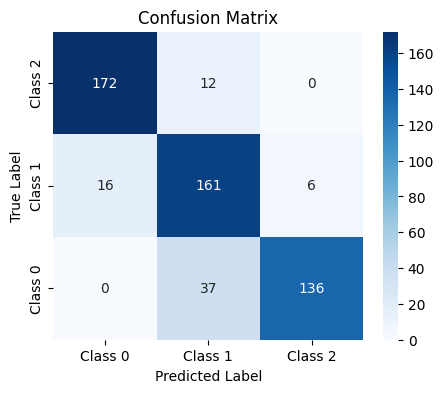

Accuracy: 0.8685
Precision: 0.8798
Recall: 0.8669
F1 Score: 0.8692


In [71]:
model1.eval()
y_true = y_test_tensor.long()
y_pred =torch.max(model1(compressed_test_tensor).data,1)[1]

num_classes = 3

# Computing confusion matrix
conf_matrix = ConfusionMatrix(task="multiclass", num_classes=num_classes)
print("Confusion Matrix:\n", conf_matrix(y_pred, y_true))
cm = conf_matrix(y_pred, y_true).cpu().numpy()

# Plotting using Seaborn
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Class 0", "Class 1","Class 2"], yticklabels=["Class 2", "Class 1" ,"Class 0"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

# Computing evaluation metrics
accuracy = Accuracy(task="multiclass", num_classes=num_classes)
precision = Precision(task="multiclass", num_classes=num_classes, average='macro')
recall = Recall(task="multiclass", num_classes=num_classes, average='macro')
f1_score = F1Score(task="multiclass", num_classes=num_classes, average='macro')

print(f"Accuracy: {accuracy(y_pred, y_true):.4f}")
print(f"Precision: {precision(y_pred, y_true):.4f}")
print(f"Recall: {recall(y_pred, y_true):.4f}")
print(f"F1 Score: {f1_score(y_pred, y_true):.4f}")


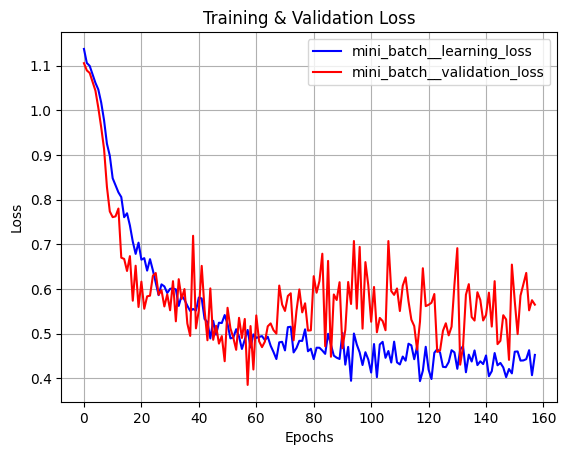

In [72]:
plt.plot(mini_batch_learning_loss, label='mini_batch__learning_loss', color='blue')
plt.plot(mini_batch_validation_loss, label='mini_batch__validation_loss', color='red')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training & Validation Loss')
plt.legend()
plt.grid()
plt.show()

### using batch gradient descent

In [73]:
train_loader =DataLoader(X_train_tensor, batch_size=len(X_train_tensor), shuffle=True)
test_loader =DataLoader(X_test_tensor, batch_size=len(X_test_tensor), shuffle=False)

In [74]:
learning_rate = 0.02
epochs = 500
patience = 50
best_loss = float('inf')
counter = 0

In [75]:
batch_learning_loss=[]
batch_validation_loss=[]
loss_function =  nn.CrossEntropyLoss()
model1 = Traffic(compressed_train_tensor.shape[1])
optimizer1 = optim.Adam(model1.parameters(), lr=learning_rate)

In [76]:
for epoch in range(epochs):
    model1.train()
    epoch_loss = 0.0

    for batch_X, batch_y in train_loader1:
        batch_y = batch_y.long()
        outputs = model1(batch_X)
        loss1 = loss_function(outputs, batch_y)
        optimizer1.zero_grad()
        loss1.backward()
        optimizer1.step()

        epoch_loss += loss1.item()
    batch_learning_loss.append(epoch_loss/len(train_loader1))

    # Validation step After training
    val_loss = 0.0
    model1.eval()

    with torch.no_grad():
        for batch_X, batch_y in test_loader1:
            outputs = model1(batch_X)
            loss1 = loss_function(outputs, batch_y.long())
            val_loss += loss1.item()
        val_loss/=len(test_loader1)
        batch_validation_loss.append(val_loss)

    print(f'Epoch [{epoch+1}/{epochs}], Loss: {epoch_loss/len(train_loader1):.4f}, Val Loss: {val_loss:.4f}')

    # Early Stopping Logic
    if val_loss < best_loss:
        best_loss = val_loss
        counter = 0
        torch.save(model1.state_dict(), 'best_model1.pth')
    else:
        counter += 1
        if counter >= patience:
            print(f'Early stopping at epoch {epoch+1}')
            break


Epoch [1/500], Loss: 1.1092, Val Loss: 1.0634
Epoch [2/500], Loss: 0.9601, Val Loss: 0.9337
Epoch [3/500], Loss: 0.7457, Val Loss: 0.6625
Epoch [4/500], Loss: 0.6703, Val Loss: 0.6373
Epoch [5/500], Loss: 0.6418, Val Loss: 0.4701
Epoch [6/500], Loss: 0.6333, Val Loss: 0.6489
Epoch [7/500], Loss: 0.5885, Val Loss: 0.4962
Epoch [8/500], Loss: 0.6150, Val Loss: 0.5029
Epoch [9/500], Loss: 0.6173, Val Loss: 0.7155
Epoch [10/500], Loss: 0.6071, Val Loss: 0.4689
Epoch [11/500], Loss: 0.5654, Val Loss: 0.5625
Epoch [12/500], Loss: 0.5619, Val Loss: 0.4658
Epoch [13/500], Loss: 0.5370, Val Loss: 0.4488
Epoch [14/500], Loss: 0.5678, Val Loss: 0.5211
Epoch [15/500], Loss: 0.5528, Val Loss: 0.4888
Epoch [16/500], Loss: 0.5554, Val Loss: 0.4267
Epoch [17/500], Loss: 0.5617, Val Loss: 0.4736
Epoch [18/500], Loss: 0.5560, Val Loss: 0.5466
Epoch [19/500], Loss: 0.5235, Val Loss: 0.4066
Epoch [20/500], Loss: 0.5419, Val Loss: 0.4321
Epoch [21/500], Loss: 0.5164, Val Loss: 0.3718
Epoch [22/500], Loss: 

In [77]:
# Loading best model parameters
model1.load_state_dict(torch.load('best_model1.pth'))

<All keys matched successfully>

Confusion Matrix:
 tensor([[158,  26,   0],
        [  9, 147,  27],
        [  0,   9, 164]])


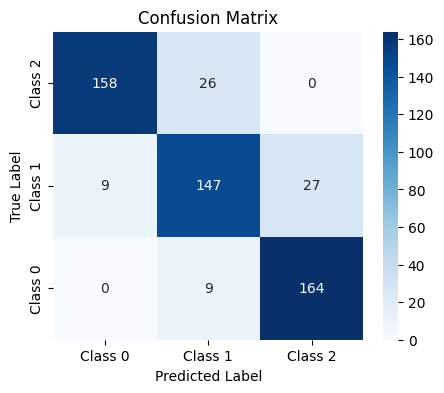

Accuracy: 0.8685
Precision: 0.8708
Recall: 0.8700
F1 Score: 0.8690


In [78]:
model1.eval()
y_true = y_test_tensor.long()
y_pred =torch.max(model1(compressed_test_tensor).data,1)[1]

num_classes = 3

# Computing confusion matrix
conf_matrix = ConfusionMatrix(task="multiclass", num_classes=num_classes)
print("Confusion Matrix:\n", conf_matrix(y_pred, y_true))
cm = conf_matrix(y_pred, y_true).cpu().numpy()

# Plotting using Seaborn
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Class 0", "Class 1","Class 2"], yticklabels=["Class 2", "Class 1" ,"Class 0"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

# Computing evaluation metrics
accuracy = Accuracy(task="multiclass", num_classes=num_classes)
precision = Precision(task="multiclass", num_classes=num_classes, average='macro')
recall = Recall(task="multiclass", num_classes=num_classes, average='macro')
f1_score = F1Score(task="multiclass", num_classes=num_classes, average='macro')

print(f"Accuracy: {accuracy(y_pred, y_true):.4f}")
print(f"Precision: {precision(y_pred, y_true):.4f}")
print(f"Recall: {recall(y_pred, y_true):.4f}")
print(f"F1 Score: {f1_score(y_pred, y_true):.4f}")


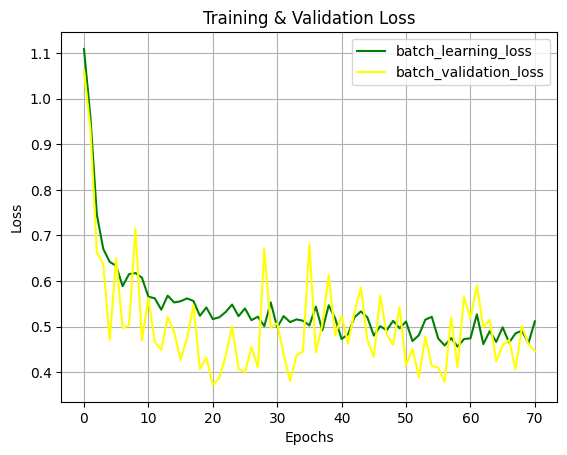

In [79]:
plt.plot(batch_learning_loss, label='batch_learning_loss', color='green')
plt.plot(batch_validation_loss, label='batch_validation_loss', color='yellow')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training & Validation Loss')
plt.legend()
plt.grid()
plt.show()

### using stochastic gradient descent

In [80]:
train_loader =DataLoader(X_train_tensor, batch_size=2, shuffle=True)
test_loader =DataLoader(X_test_tensor, batch_size=10, shuffle=False)

In [81]:
learning_rate = 0.02
epochs = 500
patience = 50
best_loss = float('inf')
counter = 0

In [82]:
stochastic_learning_loss=[]
stochastic_validation_loss=[]
loss_function =  nn.CrossEntropyLoss()
model1 = Traffic(compressed_train_tensor.shape[1])
optimizer1 = optim.Adagrad(model1.parameters(), lr=learning_rate)

In [83]:
for epoch in range(epochs):
    model1.train()
    epoch_loss = 0.0

    for batch_X, batch_y in train_loader1:
        batch_y = batch_y.long()
        outputs = model1(batch_X)
        loss1 = loss_function(outputs, batch_y)
        optimizer1.zero_grad()
        loss1.backward()
        optimizer1.step()

        epoch_loss += loss1.item()
    stochastic_learning_loss.append(epoch_loss/len(train_loader1))

    # Validation step After training
    val_loss = 0.0
    model1.eval()

    with torch.no_grad():
        for batch_X, batch_y in test_loader1:
            outputs = model1(batch_X)
            loss1 = loss_function(outputs, batch_y.long())
            val_loss += loss1.item()
        val_loss/=len(test_loader1)
        stochastic_validation_loss.append(val_loss)

    print(f'Epoch [{epoch+1}/{epochs}], Loss: {epoch_loss/len(train_loader1):.4f}, Val Loss: {val_loss:.4f}')

    # Early Stopping Logic
    if val_loss < best_loss:
        best_loss = val_loss
        counter = 0
        torch.save(model1.state_dict(), 'best_model1.pth')
    else:
        counter += 1
        if counter >= patience:
            print(f'Early stopping at epoch {epoch+1}')
            break


Epoch [1/500], Loss: 1.0994, Val Loss: 1.0694
Epoch [2/500], Loss: 1.0723, Val Loss: 1.0256
Epoch [3/500], Loss: 1.0321, Val Loss: 0.9510
Epoch [4/500], Loss: 0.9842, Val Loss: 0.9352
Epoch [5/500], Loss: 0.9343, Val Loss: 0.8429
Epoch [6/500], Loss: 0.8862, Val Loss: 0.7924
Epoch [7/500], Loss: 0.8664, Val Loss: 0.8095
Epoch [8/500], Loss: 0.8503, Val Loss: 0.7228
Epoch [9/500], Loss: 0.8349, Val Loss: 0.7388
Epoch [10/500], Loss: 0.8002, Val Loss: 0.6839
Epoch [11/500], Loss: 0.7845, Val Loss: 0.7190
Epoch [12/500], Loss: 0.7888, Val Loss: 0.6919
Epoch [13/500], Loss: 0.7624, Val Loss: 0.6614
Epoch [14/500], Loss: 0.7629, Val Loss: 0.6374
Epoch [15/500], Loss: 0.7423, Val Loss: 0.6435
Epoch [16/500], Loss: 0.7720, Val Loss: 0.6414
Epoch [17/500], Loss: 0.7241, Val Loss: 0.6037
Epoch [18/500], Loss: 0.7174, Val Loss: 0.6139
Epoch [19/500], Loss: 0.7289, Val Loss: 0.5837
Epoch [20/500], Loss: 0.7203, Val Loss: 0.5647
Epoch [21/500], Loss: 0.7318, Val Loss: 0.5991
Epoch [22/500], Loss: 

In [84]:
# Loading best model parameters
model1.load_state_dict(torch.load('best_model1.pth'))

<All keys matched successfully>

Confusion Matrix:
 tensor([[178,   6,   0],
        [ 36, 147,   0],
        [  0,  55, 118]])


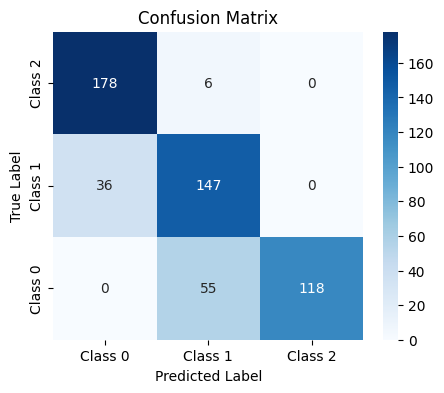

Accuracy: 0.8204
Precision: 0.8462
Recall: 0.8176
F1 Score: 0.8191


In [85]:
model1.eval()

y_true = y_test_tensor.long()
y_pred = torch.max(model1(compressed_test_tensor).data,1)[1]

num_classes = 3

# Computing confusion matrix
conf_matrix = ConfusionMatrix(task="multiclass", num_classes=num_classes)
print("Confusion Matrix:\n", conf_matrix(y_pred, y_true))
cm = conf_matrix(y_pred, y_true).cpu().numpy()

# Plotting using Seaborn
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Class 0", "Class 1","Class 2"], yticklabels=["Class 2", "Class 1" ,"Class 0"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

# Computing evaluation metrics
accuracy = Accuracy(task="multiclass", num_classes=num_classes)
precision = Precision(task="multiclass", num_classes=num_classes, average='macro')
recall = Recall(task="multiclass", num_classes=num_classes, average='macro')
f1_score = F1Score(task="multiclass", num_classes=num_classes, average='macro')

print(f"Accuracy: {accuracy(y_pred, y_true):.4f}")
print(f"Precision: {precision(y_pred, y_true):.4f}")
print(f"Recall: {recall(y_pred, y_true):.4f}")
print(f"F1 Score: {f1_score(y_pred, y_true):.4f}")


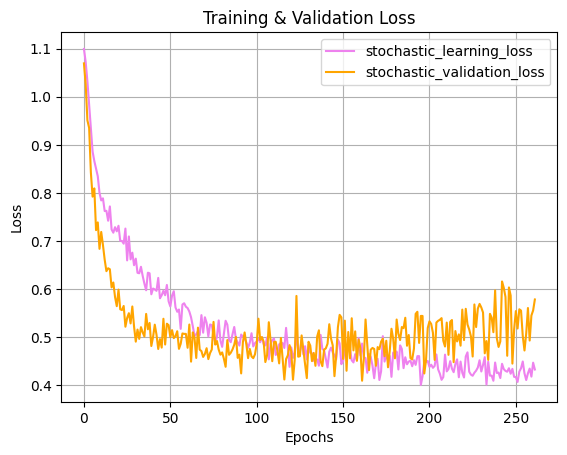

In [86]:
plt.plot(stochastic_learning_loss, label='stochastic_learning_loss', color='violet')
plt.plot(stochastic_validation_loss, label='stochastic_validation_loss', color='orange')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training & Validation Loss')
plt.legend()
plt.grid()
plt.show()